<style> h1 {text-align: center} </style>

<h1>Task 1</h1>
<p>This program implements the Needleman-Wunsch for proteins. Blosum 50 was used as the scoring matrix and thanks to it the most likely match can be calulated via dynamic progaming (with while loop, not recursion). The total sum of substitution scores and gap penalties is also displayed. The code is commented to explain each stage.</p>

In [1]:
import numpy as np

def NeedlemanWunsch(sequenceX, sequenceY, gap = -8):
    blosom50 = np.array(np.loadtxt('blosum50.txt'))
    labels = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']

    row = len(sequenceX) + 1
    col = len(sequenceY) + 1

    # Initialize with zeros
    matrix = np.zeros((row, col))
    checkingMatrix = np.zeros((row, col))

    for i in range(row - 1):
        for j in range(col - 1):
            xLetterPos = labels.index(sequenceX[i])
            yLetterPos = labels.index(sequenceY[j])
            checkingMatrix[i][j] = blosom50[xLetterPos, yLetterPos]

    # Initialise first two row and column according to gap
    for i in range(row):
        matrix[i][0] = i * gap
    for i in range(col):
        matrix[0][i] = i * gap

    # Filling the matrix
    for i in range(1, row):
        for j in range(1, col):
            matrix[i][j] = max (matrix[i-1][j-1] + checkingMatrix[i-1][j-1],
                                    matrix[i-1][j] + gap,
                                matrix[i][j-1] + gap)

    xLength = len(sequenceX)
    yLength = len(sequenceY)
    aligned_1 = ""
    aligned_2 = ""

    # Building up the aligned sequences
    while (xLength > 0 or yLength > 0):
        if (xLength > 0 and yLength > 0 and matrix[xLength][yLength] == matrix[xLength - 1][yLength - 1] + checkingMatrix[xLength - 1][yLength - 1]):
            aligned_1 = sequenceX[xLength - 1] + aligned_1
            aligned_2 = sequenceY[yLength - 1] + aligned_2

            xLength = xLength - 1
            yLength = yLength - 1

        elif(xLength > 0 and matrix[xLength][yLength] == matrix[xLength - 1][yLength] + gap):
            aligned_1 = sequenceX[xLength - 1] + aligned_1
            aligned_2 = "-" + aligned_2

            xLength = xLength - 1

        else:
            aligned_1 = "-" + aligned_1
            aligned_2 = sequenceY[yLength - 1] + aligned_2

            yLength = yLength - 1

    return aligned_1 + "\n" + aligned_2 + "\nGlobal protein alignment score: " + str(matrix[row - 1][col - 1])

<p> The given two pairs of sequences:

In [22]:
x1 = "HEAGAWGHEE"
y1 = "PAWHEAE"
print(NeedlemanWunsch(x1, y1) + "\n")

x2 = "SALPQPTTPVSSFTSGSMLGRTDTALTNTYSAL"
y2 = "PSPTMEAVTSVEASTASHPHSTSSYFATTYYHLY"
print(NeedlemanWunsch(x2, y2))

HEAGAWGHE-E
--P-AW-HEAE
Global protein alignment score: 1.0

-SALPQPTTPVSSFTSGSMLGRTDTALTNTYSAL-
PSPTMEAVTSVEA-STASHPHSTSSYFATTYYHLY
Global protein alignment score: 7.0


<style> h1 {text-align: center} </style>
<h1>Task 2</h1>
<p>This program implements the Smith-Waterman algorithm. This time it is using directions to for backwards traversal. Using the Blosum 50 to find the best local match between two sequences. The code is commented to explain each stage.</p>

In [23]:
from enum import IntEnum
import numpy as np

blosom50 = np.array(np.loadtxt('blosum50.txt'))
labels = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']

# The directions for tracing are defined
class Trace(IntEnum):
    END = 0
    LEFT = 1 
    UP = 2
    DIAGONAL = 3

# Function for checking against the Blosum 50
def checkScore (letterSeq1, letterSeq2):
    seq1LetterPos = labels.index(letterSeq1)
    seq2LetterPos = labels.index(letterSeq2)
    score = blosom50[seq1LetterPos, seq2LetterPos]
    
    return score


def SmithWaterman(seq1, seq2, gap = -8):
    row = len(seq1) + 1
    col = len(seq2) + 1
    
    # Initialize with zeros
    matrix = np.zeros((row, col))  
    tracingMatrix = np.zeros((row, col))  
    
    # For finding the max value (from where to backtrack)
    maxScore = -1
    maxScoreIndex = (-1, -1)
    
    for i in range(1, row):
        for j in range(1, col):
            # Getting the scores for each direction
            diagonalScore = matrix[i - 1, j - 1] + checkScore(seq1[i - 1], seq2[j - 1])
            verticalScore = matrix[i - 1, j] + gap
            horizontalScore = matrix[i, j - 1] + gap

            # Getting max score !Including 0!
            matrix[i, j] = max(diagonalScore, verticalScore, horizontalScore, 0)
               
            # Assigning tracing directions
            if (matrix[i, j] == 0): 
                tracingMatrix[i, j] = Trace.END
                
            elif (matrix[i, j] == horizontalScore): 
                tracingMatrix[i, j] = Trace.LEFT
                
            elif (matrix[i, j] == verticalScore): 
                tracingMatrix[i, j] = Trace.UP
                
            elif (matrix[i, j] == diagonalScore): 
                tracingMatrix[i, j] = Trace.DIAGONAL 
                
            # Finding the max value (to start backtracking from)
            if (matrix[i, j] >= maxScore):
                maxScoreIndex = (i,j)
                maxScore = matrix[i, j]
    
    aligned1 = ""
    aligned2 = ""
    (maxScoreRow, maxScoreCol) = maxScoreIndex
    
    # Backtracking to find the optimal sequence
    while (tracingMatrix[maxScoreRow, maxScoreCol] != Trace.END):
        if (tracingMatrix[maxScoreRow, maxScoreCol] == Trace.DIAGONAL):
            aligned1 = seq1[maxScoreRow - 1] + aligned1
            aligned2 = seq2[maxScoreCol - 1] + aligned2
            maxScoreRow = maxScoreRow - 1
            maxScoreCol = maxScoreCol - 1
            
        elif (tracingMatrix[maxScoreRow, maxScoreCol] == Trace.UP):
            aligned1 = seq1[maxScoreRow - 1] + aligned1
            aligned2 = '-' + aligned2
            maxScoreRow = maxScoreRow - 1    
            
        elif (tracingMatrix[maxScoreRow, maxScoreCol] == Trace.LEFT):
            aligned1 = '-' + aligned1
            aligned2 = seq2[maxScoreCol - 1] + aligned2
            maxScoreCol = maxScoreCol - 1
    
    return str(aligned1) + "\n" + str(aligned2)

<p>The given two pairs of sequences:<p> 

In [24]:
x1 = "HEAGAWGHEE"
y1 = "PAWHEAE"
print(SmithWaterman(x1, y1) + "\n")

x2 = "MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRILQVSNGCVSKILGRY"
y2 = "TDDECHSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI"
print(SmithWaterman(x2, y2))

AWGHE
AW-HE

HSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRI
HSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI


<style> h1 {text-align: center} </style>
<h1>Task 3</h1>

To test the BLAST sequence comparison algorithm I will use the online tool at https://blast.ncbi.nlm.nih.gov/.
The sequences I will be testing are:

Pax6 protein for the mouse: 
<i>MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRILQVSNGCVSKILGRY
YETGSIRPRAIGGSKPRVATPEVVSKIAQYKRECPSIFAWEIRDRLLSEGVCTNDNIPSV
SSINRVLRNLASEKQQMGADGMYDKLRMLNGQTGSWGTRPGWYPGTSVPGQPTQDGCQQQ
EGGGENTNSISSNGEDSDEAQMRLQLKRKLQRNRTSFTQEQIEALEKEFERTHYPDVFAR
ERLAAKIDLPEARIQVWFSNRRAKWRREEKLRNQRRQASNTPSHIPISSSFSTSVYQPIP
QPTTPVSSFTSGSMLGRTDTALTNTYSALPPMPSFTMANNLPMQPPVPSQTSSYSCMLPT
SPSVNGRSYDTYTPPHMQTHMNSQPMGTSGTTSTGLISPGVSVPVQVPGSEPDMSQYWPR
LQ</i>

and Eyeless protein (Fragment) of the fruit fly:
<i>NVIAMRNLPCLGTAGGSGLGGIAGKPSPTMEAVEASTASHPHSTSSYFATTYYHLTDDEC
HSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI</i>

These are the results I got:


<code> 
Score:88.2 bits(217), Expect:2e-26, 
Method:Compositional matrix adjust., 
Identities:40/41(98%), Positives:40/41(97%), Gaps:0/41(0%)

Query  5    HSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRI  45  <p><--- sequence from the mouse</p>
            HSGVNQLGGVFV GRPLPDSTRQKIVELAHSGARPCDISRI
Sbjct  61   HSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI  101 <p><--- sequence from the fly</p>
</code>

<b>Conclusion:</b>
Because E values with less than 1e-04 which is just <i>10</i><sup>-4</sup> can be considered homologous and our E value is 2e-26 it can be considered that these sequences are related.

Out of both these sequences 40 amino acids match almost exactly (out of 41) - 98%

<style> h1 {text-align: center} </style>
<h1>Task 4</h1>
<p>This program implements the Hidden Markov Machine. The code is commented to explain each stage.</p>

In [25]:
import numpy as np

nucleotides = ["A", "T", "C", "G"]
states = ["A", "C"] # A - AT rich, C - CG rich

# The emmision matrix corresponds to the probabilites of emitting A, T, C or G nucleotide (row)
# in states AT rich and CG rich (columns) respectively
emissionMatrix = np.array([
       #A      #T       #C      #G
	[0.2698, 0.3237, 0.2080, 0.1985], # AT rich
	[0.2459, 0.2079, 0.2478, 0.2984]  # CG rich
])

# The transition matrix corresponds to the probabilites of transitioning from state to the same state
# and from AT rich and CG rich respectively
transitionMatrix = np.array([
   #Same state      # Transition
	[0.9998,        0.0002],     # AT rich
	[0.0003,        0.9997]      # CG rich
])


def HMM(length):
    generatedNucleotides = ""
    generatedStates = ""

# The start matrix does not need probabilites as they are 0.5 and 0.5
# The np.random.choice() function if not given the parameter p assumes a uniform distribution over all entries
    startState = np.random.choice(2)

    currentState = startState

    for i in range(length):
        # Adding current state (within the emission is going to be made) to list
        generatedStates += states[currentState]

        # Generating a nucleotide (emission) according to state probabilities and adding to list
        generatedNucleotides += np.random.choice(nucleotides, p = emissionMatrix[currentState])

        # Generating state transition according to state transition probabilities
        currentState = np.random.choice(2, p = transitionMatrix[currentState])

    return generatedStates, generatedNucleotides



<p>Running the Hidden Markov Machine the given amount of times (length of generated string):</p>

In [26]:
(generatedStates, generatedNucleotides) = HMM(100)
print(generatedStates)
print(generatedNucleotides)

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
GATCACATAATGATCGAATGTTGCATAACTGTGCTAGTCACGCACTTTAGTTATTATTGTATAGGACTAGCCTATGACAATGTGAGTGGCGATCCAAACG


As the chance of transitioning to the other state are 0.0003 and 0.0002, we will really only see the same state and different nucleotides being generated.

<style> h1 {text-align: center} </style>
<h1>Task 5</h1>
<p>This program implements viterbi algorithm. The algorithm tries to find the maximum-likelihood the most rich CG regions in the given input.The code is commented to explain each stage.</p>

In [27]:
def viterbi(states, transitionMatrix, sequence, startStateProbabilities):

    # Define steps to build up a path
    def viterbi_step(previousViterbiLog, letter, state, transitions):
        transitionMatrixrobabilites = previousViterbiLog + np.log(transitions)
        transition_argmax = np.argmax(transitionMatrixrobabilites)
        return (transition_argmax,
                np.log(state[letter]) + transitionMatrixrobabilites[transition_argmax])

    viterbiLog = [np.log(np.array(startStateProbabilities))]
    maxStateProbabilities = np.zeros(shape=(2,len(sequence)))

    # Building path
    for i, letter in enumerate(sequence):
        viterbiLog.append(np.zeros((len(states),)))
        for j, state in enumerate(states):
            max_prob_state, v = viterbi_step(viterbiLog[i], letter, state, transitionMatrix[j])
            maxStateProbabilities[j][i] = max_prob_state
            viterbiLog[i+1][j] = v

    max_states = [np.argmax(viterbiLog[-1])]
    # Getting results
    for i in range(len(sequence) - 1):
        state = maxStateProbabilities[max_states[i]][len(sequence) - i - 1]
        max_states.append(int(state))

    return max_states[::-1]

<style> h1 {text-align: center} </style>
<h1>Task 6</h1>
<p>The viterbi algorithm implemented in Task 5 is used here to find the maximum probability estimate of rich CG regions in a bacterial virus Lambda phage. The results are plotted using matplotlib to show the regions of most probabilty to be rich in CG:</p>

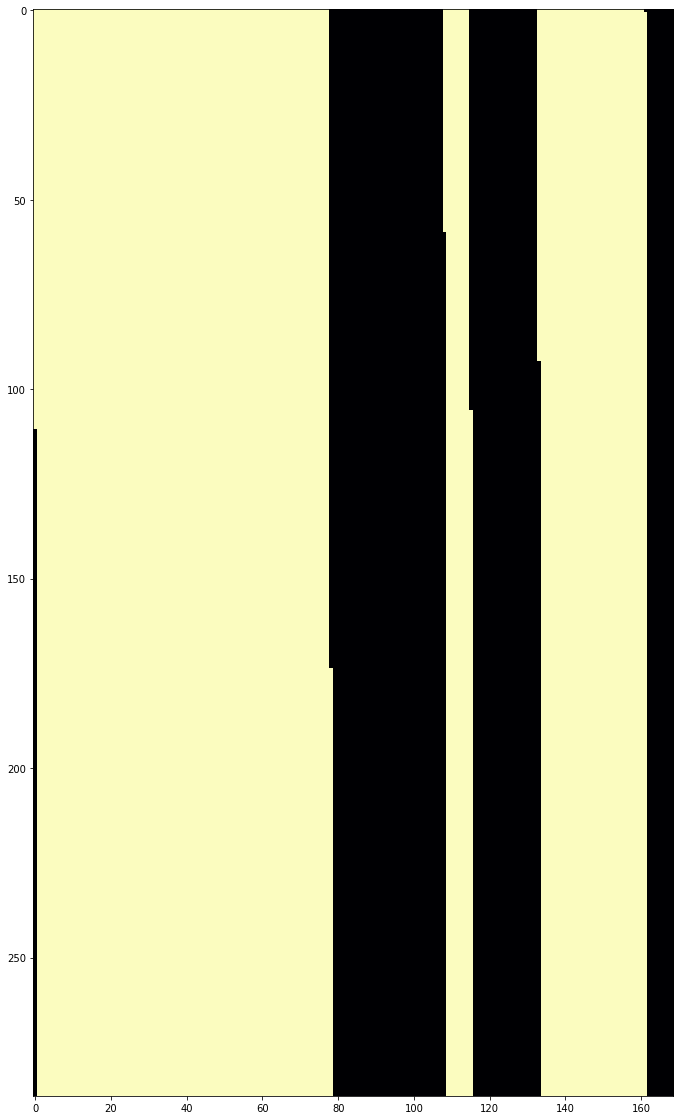

In [28]:
%matplotlib inline 
from matplotlib import pyplot as plt

# Definition of our HMM
ATrich = {'A': 0.2698, 'T': 0.3237, 'C': 0.2080, 'G': 0.1985}
CGrich = {'A': 0.2459, 'T': 0.2079, 'C': 0.2478, 'G': 0.2984}
transitionMatrix = np.array([ [0.9998, 0.0002], [0.0003, 0.9997]])
startStateProbabilities = [0.5, 0.5]

# Loading in the given genome
def loadFasta(filePath):
    with open(filePath, 'r') as f:
        data = f.read().replace('\n', '')
    return list(data)

genome = loadFasta('lambda_phage.fasta')

# Plotting the results
array = np.append(np.array(viterbi([ATrich, CGrich], transitionMatrix, genome, startStateProbabilities)), [0])
array = np.reshape(array, (169, 287))
ax = plt.subplots(figsize=(300,20))[1]
ax.imshow(np.rot90(array), cmap='magma')